In [1]:
# import libraries
import numpy as np
import sys
import psi4
from helper_PFCI import PFHamiltonianGenerator
np.set_printoptions(threshold=sys.maxsize)
import scipy
from scipy.optimize import curve_fit
from scipy import interpolate
from matplotlib import pyplot as plt
from scipy import constants
from numpy.polynomial import Polynomial
import pandas as pd
import matplotlib.colors as colors 

/var/folders/ss/883k4s4x7qj7sr5ypdpszg9n7510f8/T/ipykernel_48195/1260296890.py:13: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
array_data = "/Users/ptolley1/Documents/Github/SCQED-PCQED/array_data"
cavity_E_array_0_00_T = np.load(array_data + "/H2/fci_cavity_arrays_H2_6311G0.npy").T
cavity_E_array_0_001_T = np.load(array_data + "/H2/fci_cavity_arrays_H2_6311G0_001.npy").T
cavity_E_array_0_005_T = np.load(array_data + "/H2/fci_cavity_arrays_H2_6311G0_005.npy").T
cavity_E_array_0_01_T = np.load(array_data + "/H2/fci_cavity_arrays_H2_6311G0_01.npy").T
cavity_E_array_0_02_T = np.load(array_data + "/H2/fci_cavity_arrays_H2_6311G0_02.npy").T
cavity_E_array_0_03_T = np.load(array_data + "/H2/fci_cavity_arrays_H2_6311G0_03.npy").T
cavity_E_array_0_04_T = np.load(array_data + "/H2/fci_cavity_arrays_H2_6311G0_04.npy").T
cavity_E_array_0_05_T = np.load(array_data + "/H2/fci_cavity_arrays_H2_6311G0_05.npy").T
r_data = np.load(array_data + "/H2/fci_r_array_H2.npy")
N_R = r_data.shape[0]

## Calculation of k
Fit ground state PES of H2 to a quintic polynomial

In [3]:
def declutter_E_array(E_array, r_data, discontinuity_threshold=0.0001, energy_diff_threshold = 0.02,  num_to_declutter = 2):
    E_array = np.copy(E_array)
    new_E_array = np.zeros_like(E_array)
    for i in range(0,num_to_declutter):
        previous_intersection = 0
        for z in range(0,50):
            for j in range(i+1, E_array.shape[1]):
                array1 = E_array[:, i]
                array2 = E_array[:, j]
                array1_from_previous_intersection = array1[previous_intersection:]
                array2_from_previous_intersection = array2[previous_intersection:]
                #find closest points
                closest_indices =np.where(np.abs(array1[previous_intersection:] - array2[previous_intersection:]) < energy_diff_threshold)
                if np.shape(closest_indices)[1] != 0:
                    #print(i)
                    #print(closest_indices)
                    pass
                try:
                    dy_1 = np.gradient(np.gradient(array1_from_previous_intersection, r_data[previous_intersection:], edge_order = 2), r_data[previous_intersection:], edge_order = 2)
                    idx_1 = np.where(abs(np.diff(dy_1)) >  discontinuity_threshold)[0]+2
                    dy_2= np.gradient(np.gradient(array2_from_previous_intersection, r_data[previous_intersection:], edge_order=2), r_data[previous_intersection:], edge_order=2)
                    idx_2 = np.where(abs(np.diff(dy_2)) > discontinuity_threshold)[0]+2
                    if (len(idx_1)!= 0 and len(idx_2) != 0 ):
                        mask_idx1_idx2 = np.isin(idx_1, idx_2)
                        indices_idx1_in_idx2 = np.where(mask_idx1_idx2)[0]
                        indices_idx1_in_idx2 = idx_1[indices_idx1_in_idx2]
                        #print(indices_idx1_in_idx2)
                        starting_index=0
                        for elem_index in range(len(indices_idx1_in_idx2)-1):
                            if indices_idx1_in_idx2[elem_index]+1 == indices_idx1_in_idx2[elem_index+1]:
                                starting_index = elem_index+1
                        indices_idx1_in_idx2 = indices_idx1_in_idx2[starting_index:]
                        if(len(indices_idx1_in_idx2) != 0 ):
                            mask_discontinuties_energydiff = np.isin(indices_idx1_in_idx2, closest_indices)
                            indices_discontinuties_in_energydiff = np.where(mask_discontinuties_energydiff)[0]
                            #print(indices_discontinuties_in_energydiff)
                            if len(indices_discontinuties_in_energydiff) != 0 :
                                idx = indices_idx1_in_idx2[indices_discontinuties_in_energydiff[0]]+ previous_intersection
                                #print(idx)
                                array1_copy = np.array(array1, copy=True)
                                array1 = np.concatenate([array1[:idx],  array2[idx:]])
                                array2 =np.concatenate([array2[:idx] , array1_copy[idx:]])
                                E_array[:,i] = array1
                                E_array[:,j] = array2
                                previous_intersection = idx
                except():
                    print(i)
        new_E_array[:,i ] = E_array[:,i]
    return new_E_array

In [23]:
cavity_E_array_0_00 = declutter_E_array(cavity_E_array_0_00_T , r_data, 1, 0.05, num_to_declutter=9)
cavity_E_array_0_001  = declutter_E_array(cavity_E_array_0_001_T , r_data, 1, 0.05, num_to_declutter=9)
cavity_E_array_0_005 = declutter_E_array(cavity_E_array_0_005_T , r_data, 1, 0.05, num_to_declutter=9)
cavity_E_array_0_05  = declutter_E_array(cavity_E_array_0_05_T , r_data, 1, 0.05, num_to_declutter=9)
cavity_E_array_0_04  = declutter_E_array(cavity_E_array_0_04_T , r_data, 1, 0.05, num_to_declutter=9)
cavity_E_array_0_03  = declutter_E_array(cavity_E_array_0_03_T , r_data, 1, 0.05, num_to_declutter=9)
cavity_E_array_0_02  = declutter_E_array(cavity_E_array_0_02_T , r_data, 1, 0.05, num_to_declutter=9)
cavity_E_array_0_01  = declutter_E_array(cavity_E_array_0_01_T , r_data, 1, 0.05, num_to_declutter=9)

In [24]:
S0_array = cavity_E_array_0_00[:,0]
S1_array = cavity_E_array_0_00[:,3]


LP_arrays = np.array([cavity_E_array_0_00[:,1], 
            cavity_E_array_0_001[:,1],
            cavity_E_array_0_005[:,1],
            cavity_E_array_0_01[:,1],
            cavity_E_array_0_02[:,1],
            cavity_E_array_0_03[:,1],
            cavity_E_array_0_04[:,1],
            cavity_E_array_0_05[:,1]]
             )

UP_arrays = np.array([cavity_E_array_0_00[:,3],
            cavity_E_array_0_001[:,3],
            cavity_E_array_0_005[:,3],
            cavity_E_array_0_01[:,3],
            cavity_E_array_0_02[:,3],
            cavity_E_array_0_03[:,3],
            cavity_E_array_0_04[:,3],
            cavity_E_array_0_05[:,3]]
             )

Min on S0 is 0.7487437185929648
Min on S1 is 1.2763819095477387
        8         7         6         5         4         3         2
0.2145 x - 2.392 x + 11.58 x - 31.81 x + 54.52 x - 60.04 x + 41.82 x - 16.81 x + 1.796
533.0983457691356


<function matplotlib.pyplot.show(close=None, block=None)>

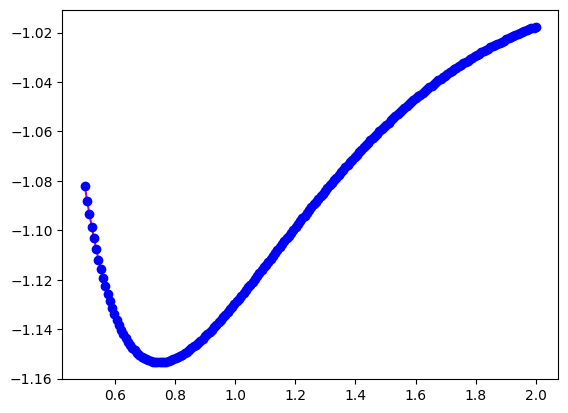

In [25]:

min_LP_array = np.zeros((1,8))
min_UP_array = np.zeros((1,8))

for i in range(8):
    min_LP_array[0,i] = np.argmin(LP_arrays[i])
    min_UP_array[0,i] = np.argmin(UP_arrays[i])

min_S0_loc = np.argmin(S0_array)
min_S1_loc = np.argmin(S1_array)

r_eq_ang = r_data[min_S0_loc]
print(f'Min on S0 is {r_data[min_S0_loc]}')
print(f'Min on S1 is {r_data[min_S1_loc]}')
#print(f'Min on LP is {r_data[min_LP_loc]}')
#print(f'Min on UP is {r_data[min_UP_loc]}')

# Fitting S0 PES to a quintic polynomial
au_to_SI = (4.35974 * 10 ** (-18)) * 10 ** 20
poly = np.poly1d(np.polyfit(r_data, S0_array, 8))
print(poly)

#Taking first and second derivative of S0 PES and evaluating at r_eq
first_derivative = poly.deriv()
second_derivative = first_derivative.deriv()
k_test_au = second_derivative(r_eq_ang)
k_test_SI = k_test_au * au_to_SI
print(k_test_SI)

#plotting S0 PES and quintic fit
plt.plot(r_data, poly(r_data), 'm-', label='fit')
plt.plot(r_data, S0_array, 'bo', label='cavity free |g>')
plt.show

## Calculation of $ \text{x}_0 $

$$ \frac{\hbar}{2}\sqrt{\frac{k}{\mu}} = \frac{k}{2}(x_0 - x_{eq})^2 + V_0 $$

Expanded, solved for $ x_o $, and found zeros using quadratic formula

In [26]:
mu_amu = 1.00784 * 1.00784 / (1.00784 + 1.00784)
mu_kg = mu_amu  * 10 ** (-3) / (6.022 * 10 ** 23) 
r_eq_SI = r_eq_ang * 10 ** (-10)
h_bar = constants.hbar
V_0_loc = np.argmin(S0_array)
V_0 = S0_array[V_0_loc] * 4.35974 * 10 ** (-18)
left = (h_bar / 2) * np.sqrt(k_test_SI / mu_kg)
a = 0.5 * k_test_SI 
b = -k_test_SI * r_eq_SI
c = 0.5 * k_test_SI * (r_eq_SI ** 2) - left
zeros_n = (-b - np.sqrt((b ** 2) - 4 * a * c)) / (2 * a)
zeros_p = (-b + np.sqrt((b ** 2) - 4 * a * c)) / (2 * a)
x0_angstrom = zeros_n * 10 ** 10
x0_au = x0_angstrom / psi4.constants.bohr2angstroms
print(x0_angstrom)
for i in range(8):
    print(LP_arrays[i,[int(min_LP_array[0,i])]])

0.6230883536659219
[-0.76733826]
[-0.76733685]
[-0.76730316]
[-0.7671979]
[-0.77092287]
[-0.77022877]
[-0.77332857]
[-0.77608944]


## Calculation of the Huang-Rhys Factor
Huang Rhys factor can be calculated by both

$$ S = 1/2(\Delta x / x_0)^2 \tag{Turner}$$

from the mode anharmonicity paper

and 

$$ S = \frac{m\omega_{vib} \Delta x^2}{2 \hbar} \tag{Hsu}$$

from the polaritonic Huang-Rhys factor paper

In [27]:
# Constants and Variables
delta_au = (r_data[min_S1_loc] - r_data[min_S0_loc]) / psi4.constants.bohr2angstroms

delta_LP_au = np.zeros((1,8))
delta_UP_au = np.zeros((1,8))

for i in range(8):
    delta_LP_au[0,i] = (r_data[int(min_LP_array[0,i])] - r_data[min_S0_loc]) / psi4.constants.bohr2angstroms
    delta_UP_au[0,i] = (r_data[int(min_UP_array[0,i])] - r_data[min_S0_loc]) / psi4.constants.bohr2angstroms


delta_m = (r_data[min_S1_loc] - r_data[min_S0_loc]) * 10 ** (-10)
delta_angstrom = (r_data[min_S1_loc] - r_data[min_S0_loc])
omega_vib = np.sqrt(k_test_SI / mu_kg)
h_bar = constants.hbar
x0_test = np.sqrt(h_bar * omega_vib / k_test_SI)
x0_test_au = (x0_test * 10 ** (10))  / psi4.constants.bohr2angstroms

# Turner
S_Turner = 0.5 * (delta_au / x0_test_au) ** 2

# Hsu
S_Hsu = mu_kg * omega_vib * delta_m ** 2 / (2 * h_bar)

#g and LP 

HR_LP_array = np.zeros((1,8))
HR_UP_array = np.zeros((1,8))

for i in range(8):
    HR_LP_array[0,i] = 0.5 * (delta_LP_au[0,i] / x0_test_au) ** 2
    HR_UP_array[0,i] = 0.5 * (delta_UP_au[0,i] / x0_test_au) ** 2

print('|g> and |e> HR Factor')
print(S_Turner)
print(S_Hsu)

print('LP and UP HR Factor')
print(HR_LP_array)
print(HR_UP_array)


df = pd.DataFrame(HR_UP_array.reshape(-1,1))
df.to_clipboard()

|g> and |e> HR Factor
8.816178569216799
8.816178569216794
LP and UP HR Factor
[[0.00719688 0.00719688 0.00719688 0.00719688 0.00179922 0.00179922
  0.         0.00179922]]
[[8.81617857 9.06986861 6.05257647 5.05400931 3.97447724 3.32675799
  2.87875219 2.46313234]]


First plot the ground-state potential energy surfaces for $ \text{H2} $ inside and outisde the cavity.  The effect of the cavity will raise the energy slightly.

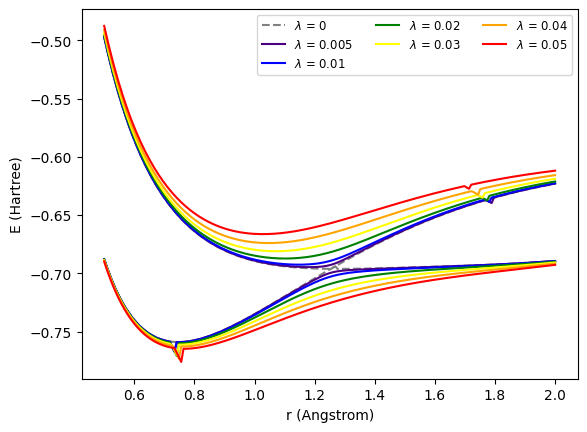

In [28]:
lambda_list = [0, 0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05]
fci_S0_omega = np.zeros((1, N_R))
for i in range(N_R):
    fci_S0_omega[0,i] = S0_array[i] + 0.3944656448298627
fci_S0_plusw = np.ndarray.flatten(fci_S0_omega)

color_list_1 = ['grey','violet','indigo','blue','green','yellow','orange','red']

plt.plot(r_data, fci_S0_plusw, linestyle='dashed', color='gray', label=f'$\lambda$ = 0')
plt.plot(r_data, S1_array, linestyle='--', color='gray')

for i in range(2,8):
    plt.plot(r_data, LP_arrays[i,:], f'{color_list_1[i]}', label=f'$\lambda$ = {lambda_list[i]}')
for k in range(2,8):
        plt.plot(r_data, UP_arrays[k,:], f'{color_list_1[k]}',)
plt.xlabel('r (Angstrom)')
plt.ylabel('E (Hartree)')


#plt.xlim(1.5, 2)
#plt.ylim(-7.76, -7.72)
plt.legend(loc = 'upper right', ncols = 3, fontsize = 'small')
plt.savefig('polariton_surfaces_H2.png',dpi=500)
#plt.show()

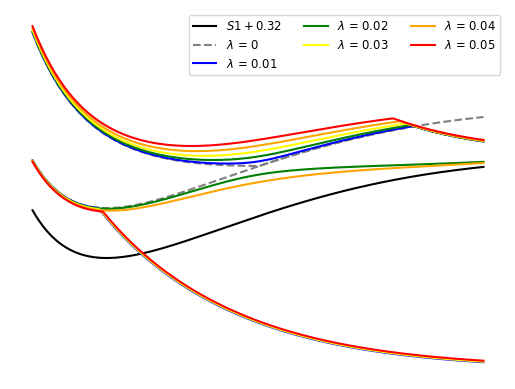

In [10]:
plt.plot(r_data, S0_array + 0.32, linestyle='-', color='black', label=f'$S1+0.32$')
plt.plot(r_data, fci_S0_plusw, linestyle='dashed', color='gray', label=f'$\lambda$ = 0')
plt.plot(r_data, S1_array, linestyle='--', color='gray')
for i in range(3,8):
    plt.plot(r_data, LP_arrays[i,:], f'{color_list_1[i]}', label=f'$\lambda$ = {lambda_list[i]}')
for k in range(3,8):
        plt.plot(r_data, UP_arrays[k,:], f'{color_list_1[k]}',)
plt.axis('off')
plt.xlabel('r (Angstrom)')
plt.ylabel('E (Hartree)')


#plt.xlim(1.5, 2)
#plt.ylim(-7.76, -7.72)
plt.legend(loc = 'upper right', ncols = 3, fontsize = 'small')
plt.savefig('ppsurfaces.png',dpi=500, transparent='True')
#plt.show()

In [ ]:
#pd.DataFrame(matrix).to_clipboard()

omega_test = np.abs(S0_array[100] - S0_array[100])
print(omega_test)
print(r_data[100])


In [ ]:

plt.plot(lambda_list, HR_UP_array[0,:], 'ro-', label='UP')
plt.plot(lambda_list, HR_LP_array[0,:], 'bo-', label='LP')
plt.legend()
plt.xlabel('Lambda')
plt.ylabel('S')
plt.savefig('H2_trends.png', dpi=1000)

In [ ]:
V_x = np.zeros((1, N_R))
x_list = np.linspace(-2, 2 ,N_R)
for i in range(N_R):
    V_x[0,i] = (x_list[i]) ** 2

V_1_x = np.zeros((1, N_R))
for i in range(N_R):
    V_1_x[0,i] = ((x_list[i] - 1) ** 2) + 2

E_0 = np.zeros((1, N_R))
for i in range(N_R):
    E_0[0,i] = 1 / 2

plt.plot(x_list, V_x[0,:], 'b-')
plt.plot(x_list, V_1_x[0,:], 'm-')
plt.plot(x_list, E_0[0,:], 'r-')
plt.savefig('x_0_fig.png', dpi=1000)